In [1]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 7.0 MB/s 


In [2]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, \
multilabel_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import hamming_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
quran_path = '/content/drive/MyDrive/TUGAS AKHIR/CODE/data quranverses TWIDF/quran_multi_label_dataset.csv'
quran = pd.read_csv(quran_path)
quran.head()

,Surah,Ayah,Text,Label
0,1,2,"Praise be to Allah, the Cherisher and Sustaine...",['muslim_ethic']
1,1,3,"Most Gracious, Most Merciful;",['pillars_of_faith']
2,1,4,Master of the Day of Judgment.,['pillars_of_faith']
3,1,6,"Show us the straight way,",['pillars_of_faith']
4,1,7,The way of those on whom Thou hast bestowed Th...,"['pillars_of_faith', 'forbiden_acts']"


In [5]:
quran.tail(10)

,Surah,Ayah,Text,Label
4044,109,5,Nor will ye worship that which I worship.,['forbiden_acts']
4045,110,2,And thou dost see the people enter Allah's Rel...,['mandatory_acts']
4046,110,3,"Celebrate the praises of thy Lord, and pray fo...","['mandatory_acts', 'muslim_ethic']"
4047,111,2,"No profit to him from all his wealth, and all ...",['pillars_of_faith']
4048,112,3,"He begetteth not, nor is He begotten;",['people_of_the_book']
4049,113,1,Say: I seek refuge with the Lord of the Dawn,['science_in_the_quran']
4050,113,2,From the mischief of created things;,['pillars_of_faith']
4051,113,4,From the mischief of those who practise secret...,"['forbiden_acts', 'science_in_the_quran']"
4052,114,2,"The King (or Ruler) of Mankind,",['pillars_of_faith']
4053,114,5,(The same) who whispers into the hearts of Man...,"['forbiden_acts', 'creation_and_creatures', 's..."


In [ ]:
df = quran.copy()
df.head()

,Surah,Ayah,Text,Label
0,1,2,"Praise be to Allah, the Cherisher and Sustaine...",['muslim_ethic']
1,1,3,"Most Gracious, Most Merciful;",['pillars_of_faith']
2,1,4,Master of the Day of Judgment.,['pillars_of_faith']
3,1,6,"Show us the straight way,",['pillars_of_faith']
4,1,7,The way of those on whom Thou hast bestowed Th...,"['pillars_of_faith', 'forbiden_acts']"


In [ ]:
df.isna().sum()

Surah    0
Ayah     0
Text     0
Label    0
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum()

Surah    0
Ayah     0
Text     0
Label    0
dtype: int64

In [ ]:
print(df.shape)

(4054, 4)


In [ ]:
df.dtypes

Surah     int64
Ayah      int64
Text     object
Label    object
dtype: object

karena df['Label'] pada dataset dibaca sebagai object/string (bukan list), maka harus diubah ke dalam bentuk list agar dapat dilakukan proses komputasi

In [ ]:
labels = list()

for lbl in df['Label']:
    txt = lbl.replace('[','').replace(']','').replace(',', '').replace("'", '').split()
    labels.append(txt)

labels[:5]

[['muslim_ethic'],
 ['pillars_of_faith'],
 ['pillars_of_faith'],
 ['pillars_of_faith'],
 ['pillars_of_faith', 'forbiden_acts']]

Kemudian label diubah ke bentuk one-hot encoding

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(labels),columns=mlb.classes_, index=df.index)

In [ ]:
y.head()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0


In [ ]:
y.describe()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
count,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000
mean,0.122595,0.427232,0.093488,0.010853,0.007153,0.115195,0.207943,0.047854,0.596201,0.051554
std,0.328012,0.494738,0.291151,0.103626,0.084285,0.319296,0.405886,0.213484,0.490719,0.221152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Karena nilai di setiap kolom y adalah integer, maka perlu diubah menjadi float

In [ ]:
for col in y.columns:
  y[col] = y[col].astype(float)

In [ ]:
y.dtypes

creation_and_creatures      float64
forbiden_acts               float64
foundations_of_the_laws     float64
invocations_in_the_quran    float64
makkah                      float64
mandatory_acts              float64
muslim_ethic                float64
people_of_the_book          float64
pillars_of_faith            float64
science_in_the_quran        float64
dtype: object

In [ ]:
y.head(3)

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


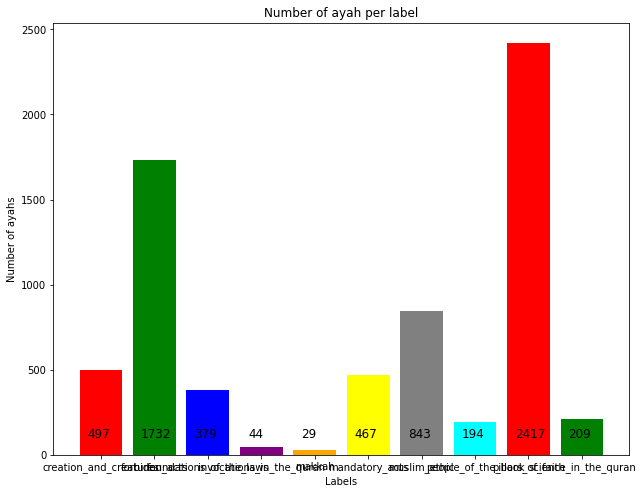

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
total_count = []
label = y.columns
for lbl in label:
    total_count.append(len(y[y[lbl] == 1]))
ax.bar(label,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'grey', 'cyan'])
for i,data in enumerate(total_count):
    plt.text(i-.25, 
              data/total_count[i]+100, 
              total_count[i], 
              fontsize=12)
plt.title('Number of ayah per label')
plt.xlabel('Labels')
plt.ylabel('Number of ayahs')

plt.show()

In [ ]:
y.sum()

creation_and_creatures       497.0
forbiden_acts               1732.0
foundations_of_the_laws      379.0
invocations_in_the_quran      44.0
makkah                        29.0
mandatory_acts               467.0
muslim_ethic                 843.0
people_of_the_book           194.0
pillars_of_faith            2417.0
science_in_the_quran         209.0
dtype: float64

### Preprocessing

#### Text Cleaning

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

punct = [char for char in string.punctuation]
stop = stopwords.words('english')
def clean_text(txt):
    text = txt.lower()
    for pun in punct:
        text = text.replace(pun, '')

    # remove stopwords
    # text = " ".join([word for word in text.split() if word not in (stop)])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['cleaned_text'] = df['Text'].apply(lambda x: clean_text(x))
df_cleaned = df.drop(['Text', 'Label'], axis=1)
df_cleaned.head()

,Surah,Ayah,cleaned_text
0,1,2,praise be to allah the cherisher and sustainer...
1,1,3,most gracious most merciful
2,1,4,master of the day of judgment
3,1,6,show us the straight way
4,1,7,the way of those on whom thou hast bestowed th...


In [ ]:
nltk.download('punkt')
tokens = [nltk.word_tokenize(text) for text in df['cleaned_text']]
df['tokens'] = tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_cleaned.head()

,Surah,Ayah,cleaned_text
0,1,2,praise be to allah the cherisher and sustainer...
1,1,3,most gracious most merciful
2,1,4,master of the day of judgment
3,1,6,show us the straight way
4,1,7,the way of those on whom thou hast bestowed th...


## Text Preprocessing with Neat Text

In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import neattext as nt
import neattext.functions as nfx

In [ ]:
df_cleaned['cleaned_text'].apply(lambda x:nt.TextFrame(x).noise_scan())

0       {'text_noise': 10.0, 'text_length': 60, 'noise...
1       {'text_noise': 7.4074074074074066, 'text_lengt...
2       {'text_noise': 10.344827586206897, 'text_lengt...
3       {'text_noise': 12.5, 'text_length': 24, 'noise...
4       {'text_noise': 12.037037037037036, 'text_lengt...
                              ...                        
4049    {'text_noise': 13.953488372093023, 'text_lengt...
4050    {'text_noise': 8.571428571428571, 'text_length...
4051    {'text_noise': 9.803921568627452, 'text_length...
4052    {'text_noise': 10.714285714285714, 'text_lengt...
4053    {'text_noise': 12.5, 'text_length': 48, 'noise...
Name: cleaned_text, Length: 4054, dtype: object

In [ ]:
df_cleaned['cleaned_text'].apply(lambda x:nt.TextExtractor(x).extract_stopwords())

0                             [be, to, the, and, of, the]
1                                            [most, most]
2                                           [of, the, of]
3                                         [show, us, the]
4       [the, of, those, on, whom, those, whose, is, n...
                              ...                        
4049                         [say, i, with, the, of, the]
4050                                      [from, the, of]
4051                          [from, the, of, those, who]
4052                                        [the, or, of]
4053                      [the, same, who, into, the, of]
Name: cleaned_text, Length: 4054, dtype: object

In [ ]:
df_cleaned['cleaned_text'].apply(nfx.remove_stopwords)

0                 praise allah cherisher sustainer worlds
1                                       gracious merciful
2                                     master day judgment
3                                            straight way
4       way thou hast bestowed thy grace portion wrath...
                              ...                        
4049                                seek refuge lord dawn
4050                              mischief created things
4051                        mischief practise secret arts
4052                                   king ruler mankind
4053                              whispers hearts mankind
Name: cleaned_text, Length: 4054, dtype: object

In [ ]:
corpus = df_cleaned['cleaned_text'].apply(nfx.remove_stopwords)

In [ ]:
corpus

0                 praise allah cherisher sustainer worlds
1                                       gracious merciful
2                                     master day judgment
3                                            straight way
4       way thou hast bestowed thy grace portion wrath...
                              ...                        
4049                                seek refuge lord dawn
4050                              mischief created things
4051                        mischief practise secret arts
4052                                   king ruler mankind
4053                              whispers hearts mankind
Name: cleaned_text, Length: 4054, dtype: object

## Extraksi Fitur Menggunakan Word Centrality

### Membuat custom TW-IDF

In [ ]:
#Importing required module
import numpy as np
from nltk.tokenize import  word_tokenize 

#Example text corpus for our tutorial
text = [a for a in corpus]
#Preprocessing the text data
sentences = []
word_set = []
 
for sent in text:
    x = [i.lower() for  i in word_tokenize(sent) if i.isalpha()]
    sentences.append(x)
    for word in x:
        if word not in word_set:
            word_set.append(word)
 
#Set of vocab 
word_set = set(word_set)
#Total documents in our corpus
total_documents = len(sentences)
 
#Creating an index for each word in our vocab.
index_dict = {} #Dictionary to store index for each word
i = 0
for word in word_set:
    index_dict[word] = i
    i += 1

In [ ]:
#Create a count dictionary
 
def count_dict(sentences):
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in sentences:
            if word in sent:
                word_count[word] += 1
    return word_count
 
word_count = count_dict(sentences)

In [ ]:
#Inverse Document Frequency
 
def inverse_doc_freq(word):
    try:
        word_occurance = word_count[word] + 1
    except:
        word_occurance = 1
    return np.log(total_documents/word_occurance)

In [ ]:
def tw_idf(sentence, centrality):
    tw_idf_vec = np.zeros((len(word_set),))
    for word in sentence:
        tw = centrality[word]
        idf = inverse_doc_freq(word)
         
        value = tw*idf
        tw_idf_vec[index_dict[word]] = value 
    return tw_idf_vec


In [ ]:
def transform_twidf(corpus,centrality,vocab,idfs):
    rows=[]
    columns=[]
    values=[]
    for ind, row in enumerate(tqdm(corpus)):
        for term,weight in centrality.items():
            col_index=vocab.get(term,-1)
            if col_index !=-1:
                if len(term)<2:
                    continue
                columns.append(col_index)
                rows.append(ind)
                values.append(idfs[term]*weight)
                spmat=csr_matrix((values, (rows,columns)), shape=(len(corpus),len(vocab)))        
    output =normalize(spmat, norm='l2', axis=1, copy=True, return_norm=False)           
    return output 

### Membuat Fungsi Extraksi Fitur TW-IDF

In [ ]:
from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix
import math
import operator
from sklearn.preprocessing import normalize
import numpy

In [ ]:
corpus = list(df_cleaned['cleaned_text'])

In [ ]:
def idf(corpus, unique_words):
    idf1={}
    N=len(corpus)
    for i in unique_words:
        count=0
        for data in corpus:
            if i in data.split():
                count=count+1
            idf1[i]=(1+math.log((1+N)/(count+1)))
    return idf1

def fit(corpus):    
    words=set()
    if isinstance(corpus, (list,)):
        for row in corpus: 
            for word in row.split(" "): 
                if len(word) < 2:
                    continue
                words.add(word)
        words = sorted(list(words))
        vocab = {j:i for i,j in enumerate(words)}
        
        idfs=idf(corpus,words)
        
        
        return vocab,idfs

In [ ]:
vocab,idfs=fit(corpus)

In [ ]:
print(len(idfs))

5665


In [ ]:
vocab.get('allah', -1)

154

In [ ]:
def find_similar_word(emmbedes):
  nearest = sorted(dc_dict.keys(), key=lambda word: spatial.distance.euclidean(dc_dict[word], emmbedes))
  return nearest

### With Stopword Removal

In [ ]:
dc = pd.read_csv('/content/drive/MyDrive/TUGAS AKHIR/CODE/data quranverses TWIDF/centrality_with_swremoval/degree_with_swremoval.csv').drop(['Unnamed: 0'], axis=1)
cc = pd.read_csv('/content/drive/MyDrive/TUGAS AKHIR/CODE/data quranverses TWIDF/centrality_with_swremoval/closeness_with_swremoval.csv').drop(['Unnamed: 0'], axis=1)
bc = pd.read_csv('/content/drive/MyDrive/TUGAS AKHIR/CODE/data quranverses TWIDF/centrality_with_swremoval/betweenness_with_swremoval.csv').drop(['Unnamed: 0'], axis=1)

Mengubah dataframe ke dalam bentuk DICTIONARY untuk proses ekstraksi fitur

In [ ]:
def todict(centrality):
    dictionary = {}
    for idx in range(len(centrality)):
        key = centrality['word'][idx]
        value = centrality['centrality'][idx]
        dictionary[key] = value

    return dictionary

dc_dict = todict(dc)
cc_dict = todict(cc)
bc_dict = todict(bc)

In [ ]:
print('SHAPE:')
print('Degree Centrality:', dc.shape)
print('Closeness Centrality:', cc.shape)
print('Betweenness Centrality:', bc.shape)

SHAPE:
Degree Centrality: (6370, 2)
Closeness Centrality: (6370, 2)
Betweenness Centrality: (6370, 2)


In [ ]:
dc.nunique()

word          6370
centrality     204
dtype: int64

In [ ]:
word_unique = []

for text in corpus:
  for word in text.split():
    if word not in word_unique:
      word_unique.append(word)


In [ ]:
len(word_unique)

5672

checkpoint 03/07/22 00:06

**BELUM DIPISAH TAHAP VEKTORISASI SETIAP WORD CENTRALITY**

In [ ]:
twidf_dc = []

for sent in sentences:
    vec = tw_idf(sent, dc_dict)
    twidf_dc.append(vec)
 

In [ ]:
twidf_cc = []

for sent in sentences:
    vec = tw_idf(sent, cc_dict)
    twidf_cc.append(vec)

In [ ]:
twidf_bc = []

for sent in sentences:
    vec = tw_idf(sent, bc_dict)
    twidf_bc.append(vec)

# Training Model

In [ ]:
def pipeline_nb(alpha):
  hamming = []
  for al in alpha:
    nb_cc = ClassifierChain(MultinomialNB(alpha = al))
    nb_br = BinaryRelevance(MultinomialNB(alpha = al))
    nb_lp = LabelPowerset(MultinomialNB(alpha = al))

    nb_cc.fit(X_train, y_train)
    nb_br.fit(X_train, y_train)
    nb_lp.fit(X_train, y_train) 

    pred1 = nb_cc.predict(X_test)
    pred2 = nb_br.predict(X_test)
    pred3 = nb_lp.predict(X_test)

    print('\nalpha = ', str(al))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [ ]:
def pipeline_knn(n_neighbors):
  hamming = []
  for neigh in n_neighbors:
    knn_cc = ClassifierChain(KNeighborsClassifier(n_neighbors=neigh))
    knn_br = BinaryRelevance(KNeighborsClassifier(n_neighbors=neigh))
    knn_lp = LabelPowerset(KNeighborsClassifier(n_neighbors=neigh))

    knn_cc.fit(X_train, y_train)
    knn_br.fit(X_train, y_train)
    knn_lp.fit(X_train, y_train)

    pred1 = knn_cc.predict(X_test)
    pred2 = knn_br.predict(X_test)
    pred3 = knn_lp.predict(X_test)

    print('\nn_neighbors = ', str(neigh))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [ ]:
def pipeline_svm(kernel, gamma):
  hamming = []
  for ker in kernel:
    for g in gamma :
      svm_cc = ClassifierChain((SVC(kernel=ker, gamma=g)))
      svm_br = BinaryRelevance((SVC(kernel=ker, gamma=g)))
      svm_lp = LabelPowerset((SVC(kernel=ker, gamma=g)))

      svm_cc.fit(X_train, y_train)
      svm_br.fit(X_train, y_train)
      svm_lp.fit(X_train, y_train)

      pred1 = svm_cc.predict(X_test)
      pred2 = svm_br.predict(X_test)
      pred3 = svm_lp.predict(X_test)

      print('\nkernel = %s, gamma = %s' % (str(ker), str(g)))
      print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
      print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
      print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

      hamming.append(hamming_loss(y_test, pred1))   
      hamming.append(hamming_loss(y_test, pred2))   
      hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [ ]:
def pipeline_dt(random_state):
  hamming = []
  for ran in random_state:
    dt_cc = ClassifierChain(DecisionTreeClassifier(random_state=ran))
    dt_br = BinaryRelevance(DecisionTreeClassifier(random_state=ran))
    dt_lp = LabelPowerset(DecisionTreeClassifier(random_state=ran))

    dt_cc.fit(X_train, y_train)
    dt_br.fit(X_train, y_train)
    dt_lp.fit(X_train, y_train)

    pred1 = dt_cc.predict(X_test)
    pred2 = dt_br.predict(X_test)
    pred3 = dt_lp.predict(X_test)

    print('\nrandom state = ', str(ran))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

## Degree Centrality

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twidf_dc, y, test_size=0.2, random_state=42)

In [ ]:
print('X_train shape :', len(X_train))
print('y_train shape :', len(y_train))
print('X_test shape :', len(X_test))
print('y_test shape :', len(y_test))

X_train shape : 3243
y_train shape : 3243
X_test shape : 811
y_test shape : 811


### Train Model

**Naive Bayes**

In [ ]:
alpha = [0.1, 1.0, 10, 100]

pipeline_nb(alpha)


alpha =  0.1
hamming loss (Classifier Chain): 0.1467324290998767
hamming loss (Binary Relevance): 0.14882860665844636
hamming loss (Label Powerset): 0.1495684340320592

alpha =  1.0
hamming loss (Classifier Chain): 0.149691738594328
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

alpha =  10
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

alpha =  100
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

BEST :  0.1467324290998767


**KNN**

In [ ]:
n_neighbors = [8, 10, 20, 64]

pipeline_knn(n_neighbors)


n_neighbors =  8
hamming loss (Classifier Chain): 0.14808877928483355
hamming loss (Binary Relevance): 0.14882860665844636
hamming loss (Label Powerset): 0.1535141800246609

n_neighbors =  10
hamming loss (Classifier Chain): 0.14599260172626388
hamming loss (Binary Relevance): 0.1500616522811344
hamming loss (Label Powerset): 0.155980271270037

n_neighbors =  20
hamming loss (Classifier Chain): 0.14734895191122072
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.15252774352651047

n_neighbors =  64
hamming loss (Classifier Chain): 0.14944512946979038
hamming loss (Binary Relevance): 0.15141800246609124
hamming loss (Label Powerset): 0.15018495684340322

BEST :  0.14599260172626388


**SVM**

In [ ]:
kernel = ["rbf", "linear"]
gamma = [0.1, "auto", "scale"]

pipeline_svm(kernel, gamma)


kernel = rbf, gamma = 0.1
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

kernel = rbf, gamma = auto
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

kernel = rbf, gamma = scale
hamming loss (Classifier Chain): 0.13674475955610357
hamming loss (Binary Relevance): 0.12922318125770654
hamming loss (Label Powerset): 0.14019728729963007

kernel = linear, gamma = 0.1
hamming loss (Classifier Chain): 0.14463625154130702
hamming loss (Binary Relevance): 0.14648581997533908
hamming loss (Label Powerset): 0.14907521578298397

kernel = linear, gamma = auto
hamming loss (Classifier Chain): 0.14463625154130702
hamming loss (Binary Relevance): 0.14648581997533908
hamming loss (Label Powerset): 0.14907521578298397

kernel = linear, gamma = scale
hamming loss (Classifier Chain): 0.144636251

**Decision Tree**

In [ ]:
random_state = [0, None]

pipeline_dt(random_state)


random state =  0
hamming loss (Classifier Chain): 0.1311960542540074
hamming loss (Binary Relevance): 0.1249075215782984
hamming loss (Label Powerset): 0.1462392108508015

random state =  None
hamming loss (Classifier Chain): 0.12860665844636252
hamming loss (Binary Relevance): 0.1249075215782984
hamming loss (Label Powerset): 0.14512946979038224

BEST :  0.1249075215782984


## Closeness Centrality

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twidf_cc, y, test_size=0.2, random_state=42)

In [ ]:
print('X_train shape :', len(X_train))
print('y_train shape :', len(y_train))
print('X_test shape :', len(X_test))
print('y_test shape :', len(y_test))

X_train shape : 3243
y_train shape : 3243
X_test shape : 811
y_test shape : 811


### Train Model

**Naive Bayes**

In [ ]:
alpha = [0.1, 1.0, 10]

pipeline_nb(alpha)


alpha =  0.1
hamming loss (Classifier Chain): 0.17657213316892725
hamming loss (Binary Relevance): 0.18347718865598028
hamming loss (Label Powerset): 0.14796547472256474

alpha =  1.0
hamming loss (Classifier Chain): 0.15524044389642416
hamming loss (Binary Relevance): 0.17016029593094945
hamming loss (Label Powerset): 0.12762022194821207

alpha =  10
hamming loss (Classifier Chain): 0.12244143033292232
hamming loss (Binary Relevance): 0.12515413070283601
hamming loss (Label Powerset): 0.13489519112207152

BEST :  0.12244143033292232


**KNN**

In [ ]:
n_neighbors = [8, 10, 20, 64]

pipeline_knn(n_neighbors)


n_neighbors =  8
hamming loss (Classifier Chain): 0.15400739827373613
hamming loss (Binary Relevance): 0.15795314426633786
hamming loss (Label Powerset): 0.155980271270037

n_neighbors =  10
hamming loss (Classifier Chain): 0.15733662145499383
hamming loss (Binary Relevance): 0.15733662145499383
hamming loss (Label Powerset): 0.15511713933415536

n_neighbors =  20
hamming loss (Classifier Chain): 0.14821208384710235
hamming loss (Binary Relevance): 0.15758323057953144
hamming loss (Label Powerset): 0.15191122071516647

n_neighbors =  64
hamming loss (Classifier Chain): 0.1495684340320592
hamming loss (Binary Relevance): 0.15154130702836005
hamming loss (Label Powerset): 0.14858199753390874

BEST :  0.14821208384710235


**SVM**

In [ ]:
kernel = ["rbf", "linear"]
gamma = [0.1, "auto", "scale"]

pipeline_svm(kernel, gamma)


kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1405672009864365
hamming loss (Binary Relevance): 0.1382244143033292
hamming loss (Label Powerset): 0.1462392108508015

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.12379778051787917
hamming loss (Binary Relevance): 0.11997533908754623
hamming loss (Label Powerset): 0.13588162762022196

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1283600493218249
hamming loss (Binary Relevance): 0.12515413070283601
hamming loss (Label Powerset): 0.12700369913686807

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1283600493218249
hamming loss (Binary Relevance): 0.12515413070283601
hamming loss (Label Powerset): 0.12700369913686807

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1283600493218249
hamming loss (Binary 

**Decision Tree**

In [ ]:
random_state = [0, None]

pipeline_dt(random_state)


random state =  0
hamming loss (Classifier Chain): 0.13070283600493218
hamming loss (Binary Relevance): 0.12577065351418001
hamming loss (Label Powerset): 0.143403205918619

random state =  None
hamming loss (Classifier Chain): 0.13267570900123304
hamming loss (Binary Relevance): 0.1247842170160296
hamming loss (Label Powerset): 0.14759556103575833

BEST :  0.1247842170160296


## Betweenness Centrality

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twidf_bc, y, test_size=0.2, random_state=42)

In [ ]:
print('X_train shape :', len(X_train))
print('y_train shape :', len(y_train))
print('X_test shape :', len(X_test))
print('y_test shape :', len(y_test))

X_train shape : 3243
y_train shape : 3243
X_test shape : 811
y_test shape : 811


### Train Model

**Naive Bayes**

In [ ]:
alpha = [0.1, 1.0, 10]

pipeline_nb(alpha)


alpha =  0.1
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

alpha =  1.0
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

alpha =  10
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

BEST :  0.1498150431565968


**KNN**

In [ ]:
n_neighbors = [8, 10, 20, 64]

pipeline_knn(n_neighbors)


n_neighbors =  8
hamming loss (Classifier Chain): 0.15104808877928483
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.15536374845869297

n_neighbors =  10
hamming loss (Classifier Chain): 0.14907521578298397
hamming loss (Binary Relevance): 0.14932182490752158
hamming loss (Label Powerset): 0.1533908754623921

n_neighbors =  20
hamming loss (Classifier Chain): 0.15166461159062886
hamming loss (Binary Relevance): 0.1500616522811344
hamming loss (Label Powerset): 0.15462392108508013

n_neighbors =  64
hamming loss (Classifier Chain): 0.14648581997533908
hamming loss (Binary Relevance): 0.14796547472256474
hamming loss (Label Powerset): 0.15092478421701602

BEST :  0.14648581997533908


**SVM**

In [ ]:
kernel = ["rbf", "linear"]
gamma = [0.1, "auto", "scale"]

pipeline_svm(kernel, gamma)


kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.14808877928483355
hamming loss (Binary Relevance): 0.14130702836004932
hamming loss (Label Powerset): 0.14821208384710235

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Relevance): 0.1498150431565968
hamming loss (Label Powerset): 0.1498150431565968

kernel = %s, gamma = %s
hamming loss (Classifier Chain): 0.1498150431565968
hamming loss (Binary Rele

**Decision Tree**

In [ ]:
random_state = [0, None]

pipeline_dt(random_state)


random state =  0
hamming loss (Classifier Chain): 0.13045622688039457
hamming loss (Binary Relevance): 0.1256473489519112
hamming loss (Label Powerset): 0.14389642416769421

random state =  None
hamming loss (Classifier Chain): 0.12860665844636252
hamming loss (Binary Relevance): 0.12330456226880394
hamming loss (Label Powerset): 0.14451294697903821

BEST :  0.12330456226880394
